In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick

Let's start with the calendar file, loading it and taking a quick look into its features

In [3]:
calendar = pd.read_csv(r"U:\Personal\Estudiaciones\Udacity\Data_Scientist\Project_1\calendar.csv")
calendar.head()
calendar.info()
calendar.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


Index(['listing_id', 'date', 'available', 'price'], dtype='object')

It is a quite straightforward, showing the amount of reservations done throughout a year, along with its price and an availability check. The date column is in a Y/M/D format which is not the most convinient. 

We are going to start by analizing a little bit this column:

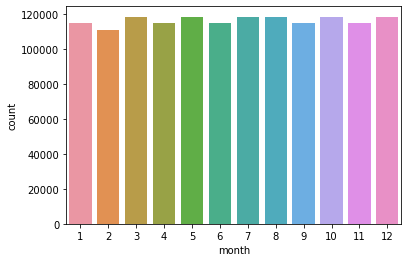

In [4]:
"In order to get a summary of the dates where there are more reservations and action on the market lets deep dive into it:"
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
month_distribution = calendar.groupby('month').size().reset_index(name='count')
Monthly_reservations_plot=sns.barplot(data=month_distribution, x='month', y='count')

This first plot gives us the amount of reservations done throught the year, which is not really giving us any deep insight into the dataset.
A good approach could be to look into the availability and how it changes throughout the year, instead of the total reservations number.

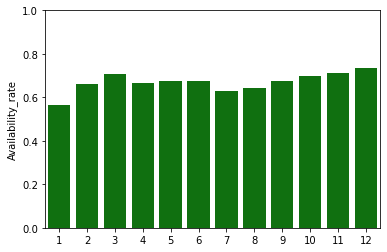

In [5]:
availability_counts = calendar[calendar['available'] == 't'].groupby('month').size()
availability_counts.name = 'count_avg'
month_distribution = month_distribution.join(availability_counts, on='month').fillna(0)
month_distribution['Availability_rate'] = month_distribution['count_avg'] / month_distribution['count']
Av_rate_plot=sns.barplot(data=month_distribution, x=month_distribution.index + 1, y='Availability_rate', color='green').set_ylim(0, 1)

Now, this is much better.

From the plot we just created, there is a much more clear information exposure, with values in availability from ~0.55 up to ~0.7.
January is the worst month to get a reservation done, along with the summer months. On the other hand, march and later in the year are on the upper end of the availability rates.

Then we can look into the monthly price distributions to have a better look:

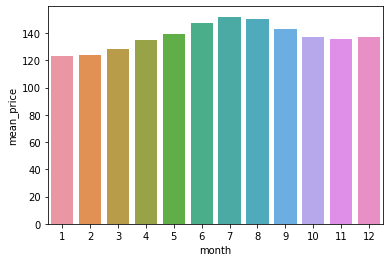

In [7]:
'First we need to wrangle a bit the price column, so we dont have the $ sign or any commas or dots'
calendar['price'] = calendar['price'].str.strip('$').str.replace(',', '').astype(float)
mean_prices = calendar[~calendar['price'].isnull()].groupby('month')['price'].mean()
mean_prices.name = 'mean_price'
month_distribution = month_distribution.join(mean_prices, on='month')                    
Mean_prices_plot=sns.barplot(data=month_distribution, x='month', y='mean_price')

On a similar fashion to what we saw with the availability rate, summer months are the worst in terms of mean reservation price as well, although in january seems to be a discrepancy between the price and the availability. 

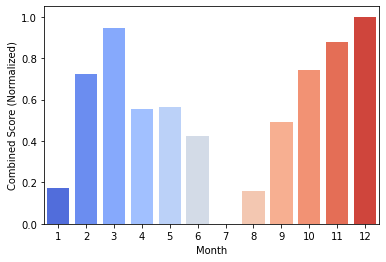

In [15]:
"Finally, in we can normalize the results to create a new parameter, which we will name combined_score_normalized which will give us a number between 0 and 1, where 1 is the most optimum time to book a reservation and 0 the least, taking into account both the price and the availability."
from sklearn.preprocessing import MinMaxScaler

combined_score = (1 - month_distribution['Availability_rate']) * (1 - month_distribution['mean_price'])
scaler = MinMaxScaler()
combined_score_normalized = scaler.fit_transform(combined_score.values.reshape(-1, 1)).flatten()
month_distribution['combined_score_normalized'] = combined_score_normalized

sns.barplot(data=month_distribution, x='month', y='combined_score_normalized', palette='coolwarm', saturation=1)
plt.xlabel('Month')
plt.ylabel('Combined Score (Normalized)')
plt.show()

With this last plot we've divided the year in two semesters, from january to june and from july until the end of the year. With the heat map distribution we can see in the combined score of both the price and the availability rate that march and december are the best months to make a reservation.
It is also quite interesting that april, may, june and september have all a similar index refering to this metric.

After this first introduction we can look into the next dataset, the listings.csv file:

In [18]:
listings = pd.read_csv(r"U:\Personal\Estudiaciones\Udacity\Data_Scientist\Project_1\listings.csv")
listings.head()
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

This is a shorter file, but there are lots of categories and columns where we can get information from. We will start by looking at the rating scores parameters:

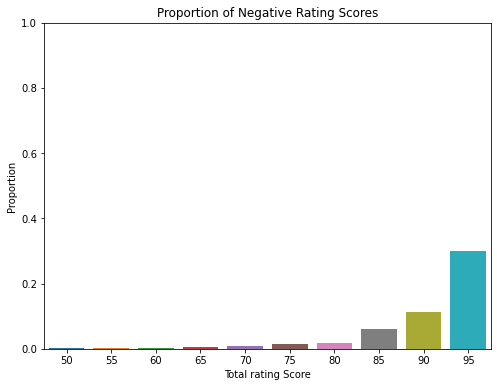

In [21]:
"Another interesting question is to take a look into the amount of positive reviews that are being given by the customers: "
rating_scores=listings[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]
proportion = pd.DataFrame()  # Initialize the Dataframe

for i in range(50, 96, 5):
    negative = rating_scores['review_scores_rating'][rating_scores['review_scores_rating'] < i].count()
    proportion = pd.concat([proportion, pd.DataFrame([negative / rating_scores.shape[0]], [i])])
    
proportion.reset_index(inplace=True)
proportion.columns = ['Rating Score', 'Proportion']

"In the following plot it is observed the amount of negative rating scores in a cumulative way, and only when we set the threshold at 95 points score we see a significant negative proportion, otherwise its under 10%"
plt.figure(figsize=(8, 6))
sns.barplot(x='Rating Score', y='Proportion', data=proportion)
plt.xlabel('Total rating Score')
plt.ylabel('Proportion')
plt.ylim(0,1)
plt.title('Proportion of Negative Rating Scores')
plt.show()    


The results are definitely good in this metric. Only when we set the threshold at a score below 90 we see any relevant amount of bad reviews and it is still at barely ~10%. Even at 95 out of 100 the proportion is under 40% of negative reviews.

Finally we can also take a look into the mean ratings for the other categories, not only the total rating score:

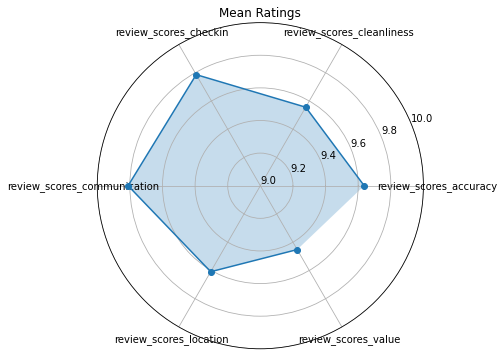

In [24]:
categories = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
              'review_scores_communication', 'review_scores_location', 'review_scores_value']
mean_rating_values=rating_scores.dropna().mean().drop('review_scores_rating')
mean_rating_values = mean_rating_values[:len(categories)]


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)

theta = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)

ax.plot(theta, mean_rating_values, marker='o')
ax.fill(theta, mean_rating_values, alpha=0.25)

ax.set_xticks(theta)
ax.set_xticklabels(categories)
ax.set_rticks(np.arange(9, 11, 0.2))  # Establecer los ticks del eje radial
ax.set_rlim(9, 10)  # Establecer los límites del eje radial


plt.title('Mean Ratings')
plt.show()


First of all, it is important to note that every rating is scored at a minumum of 9 points out ot 10, so for better visualization, we will just focus on said range.


Even in this range we can see some differences, specially in the check in and communication scores, which are almost perfect overall. This indicates that the procedure of the AirBNB app is quite solid and people almost always consider it great.

On the other hand, qualities such as cleanliness or location which are more dependant on the personal or subjective preferences show worse values, which are still really high nonetheless, but it gives the dataset credibility and authenticity.